The neural network varies form statistical approach. It is more sensitive and prone to overfitting and ignoring the minority classes especially for binary classification model. Since the network is learning the result, the data should be balanced to produce an accurate representation of the model based on fairly proportional input. The readmission binary categorical classification variable of the model is imbalanced. The number of positive readmitted patients is much larger than those whom did not readmitted. The ratio of positive reemission is over 10 times the size of the not readmitted which indicates that more than 90% of the classification variable are of the same class. The ANN sequential model with sigmoid will produce an overfitting result with high accuracy of 91 % and very low precision and recall. In addition the model will not exhibit any learning process. The lost and accuracy will remain constant throughout the learning process. To overcome the problem a different approaches where conducted. The class-weigh and SMOTE methods where selected to predict the readmission classifications. The weight method treat every instance of minority class as multiple instance of majority class based on the ratio between the two classes. It means the loss function will assign a higher value to these minority instances using the ratio between majority and minority classes. Thus, the loss becomes a weighted average, where the weight of each sample is specified by its corresponding class. The model exhibits moderate predicted accuracy value of 82%. The precision of the model is 91% and the recall is 88%.


The Sampling method utilizes the SMOTE algorithm which an oversampling method based on synthetic minority oversampling technique uses k-nearest neighbors to create synthetic examples of the minority class. It injects the SMOTE method at each iteration. The advantage of this approach is that while standard boosting gives equal weights to all misclassified data, SMOTE gives more examples of the minority class at each boosting step. The model produces and highly correlated result with 92 % accuracy. This result is confirmed by the high precision of 87% and 99% of recall.


In [320]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras.backend as K
#K.clear_session()
import numpy
import numpy as np
import pandas

import keras
import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import seaborn as sns
seed = 123
%matplotlib inline


In [321]:
# load dataset
df = pd.read_csv('diabetes_data_preprocessed.csv',low_memory=False)
df=df.drop("Unnamed: 0", axis=1)

# convert age back to integer type
df['age'] = df['age'].astype('int64')
print(df.age.value_counts())
# convert age categories to mid-point values
age_dict = {1:5, 2:15, 3:25, 4:35, 5:45, 6:55, 7:65, 8:75, 9:85, 10:95}
df['age'] = df.age.map(age_dict)

df['race'] = df['race'].replace('?', "Unknown")
sum(df['race']=='?')

col=df.columns
GRGs=list(filter(lambda x: x.startswith("D"), col))
GRGs.remove('DRG') 

df=df.drop(GRGs,axis=1)
numerics = list(set(list(df._get_numeric_data().columns)) - {'level2_diag1','patient_nbr'
                                                             'encounter_id'})
dataframe=df[numerics]
print(dataframe.shape)
dataframe.columns

8     18098
7     15823
6     12303
9     11533
5      6711
4      2589
10     1898
3      1037
2       360
1        64
Name: age, dtype: int64
(70416, 49)


Index(['time_in_hospital', 'level1_diag3', 'level2_diag3',
       'glimepiride.pioglitazone', 'admission_type_id', 'number_outpatient',
       'level2_diag2', 'num_procedures', 'glimepiride',
       'discharge_disposition_id', 'number_inpatient', 'rosiglitazone',
       'metformin.pioglitazone', 'readmitted', 'A1Cresult', 'level1_diag1',
       'glyburide', 'insulin', 'num_medications', 'encounter_id', 'metformin',
       'acarbose', 'diabetesMed', 'nummed', 'acetohexamide', 'change',
       'tolbutamide', 'metformin.rosiglitazone', 'DRG', 'troglitazone',
       'max_glu_serum', 'age', 'glyburide.metformin', 'glipizide',
       'number_diagnoses', 'pioglitazone', 'nateglinide', 'level1_diag2',
       'repaglinide', 'glipizide.metformin', 'service_utilization',
       'number_emergency', 'chlorpropamide', 'num_lab_procedures',
       'tolazamide', 'miglitol', 'admission_source_id', 'patient_nbr',
       'numchange'],
      dtype='object')

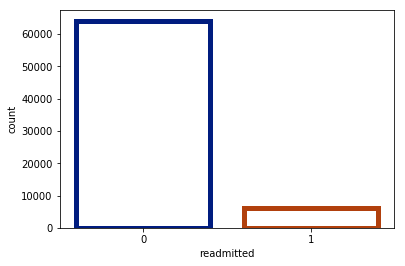

In [322]:
sns.countplot(dataframe['readmitted'],facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3), label = "Count")

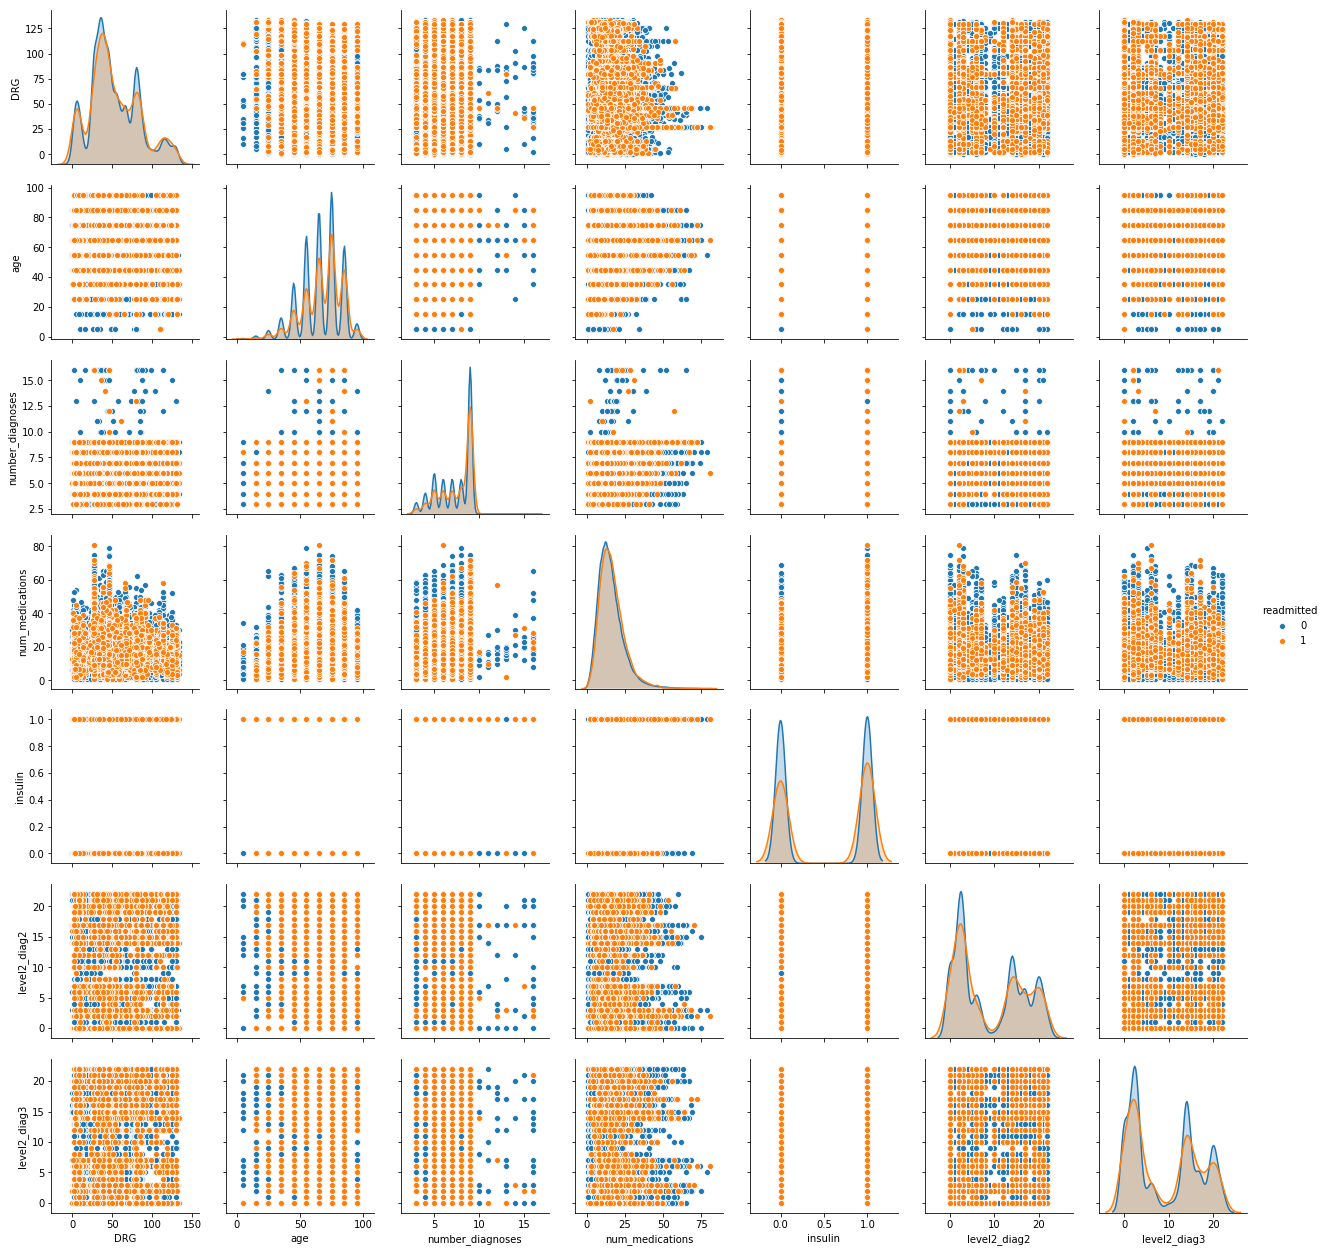

In [326]:
sns.pairplot(dataframe, hue='readmitted', vars = ['DRG', 'age', 'number_diagnoses', 'num_medications','insulin','level2_diag2','level2_diag3'])

In [328]:
keys= ['level2_diag2', 'level2_diag3', 'time_in_hospital', 'number_diagnoses','DRG',
       'num_medications', 'discharge_disposition_id','admission_source_id',  
       'service_utilization', 'age', 'number_outpatient','num_procedures', 'num_lab_procedures', 'admission_type_id']

# Onehotencoder works with a matrix of integers whereas getdummies works with a dataframe
def create_dummies(dftemp,column_name):
    dummies = pd.get_dummies(dftemp[column_name],prefix=column_name)
    #print(dummies.columns)
    dftemp = pd.concat([dftemp,dummies],axis=1)
    return dftemp

for i in keys:
    dataframe = create_dummies(dataframe,str(i))
    del dataframe[i]
dataframe.shape

(70416, 539)

In [329]:
y=dataframe.readmitted
print(y[:2])
ratio=sum(y[:]==0)/sum(y[:]==1)
print("ratio :",ratio)
print(y.shape)

0    0
1    0
Name: readmitted, dtype: int64
ratio : 10.26656
(70416,)


In [330]:
dataframe=dataframe.drop('readmitted',axis=1)
dataset=dataframe.values
x=dataset.astype(float)
x.shape
print(dataset.shape)

(70416, 538)


In [331]:
#standardizing the input feature
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(x)
X

array([[-0.93518286,  0.        , -0.23579941, ..., -0.49143731,
        -0.01130611, -0.35593827],
       [-0.93518286,  0.        , -0.23579941, ..., -0.49143731,
        -0.01130611, -0.35593827],
       [-0.48161408,  0.        , -0.23579941, ..., -0.49143731,
        -0.01130611, -0.35593827],
       ...,
       [-0.48161408,  0.        , -0.23579941, ..., -0.49143731,
        -0.01130611, -0.35593827],
       [-0.93518286,  0.        , -0.23579941, ..., -0.49143731,
        -0.01130611, -0.35593827],
       [ 0.42552347,  0.        , -0.23579941, ..., -0.49143731,
        -0.01130611, -0.35593827]])

# Sequential Model

In [478]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [479]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
from sklearn.utils import class_weight
encoder = LabelEncoder()
encoder.fit(y)
y_train= encoder.transform(y_train)
y_test= encoder.transform(y_test)
class_weight_list =class_weight.compute_class_weight('balanced', numpy.unique(y_train), y_train)
class_weight = dict(zip(numpy.unique(y_train), class_weight_list))
y_train=keras.utils.np_utils.to_categorical(y_train, 2)  
y_test=keras.utils.np_utils.to_categorical(y_test, 2)

In [480]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [481]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
#First Hidden Layer
model.add(Dense(269, activation='relu', kernel_initializer='random_normal', input_dim=538))
model.add(Dropout(0.5))
#Second  Hidden Layer
model.add(Dense(269, activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.2))
#Second  Hidden Layer
model.add(Dense(134, activation='relu', kernel_initializer='random_normal'))
#Output Layer
model.add(Dense(2, activation='sigmoid', kernel_initializer='random_normal'))

In [482]:
#Compiling the neural network
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [483]:
hist = model.fit(X_train,y_train,
               batch_size=20, 
               epochs=200,
               class_weight=class_weight,
               validation_data=(X_test, y_test)
              )

Train on 49291 samples, validate on 21125 samples
Epoch 1/200
49291/49291 [==============================] - 16s 333us/step - loss: 0.6779 - acc: 0.5949 - val_loss: 0.6130 - val_acc: 0.6626
Epoch 2/200
49291/49291 [==============================] - 12s 237us/step - loss: 0.6514 - acc: 0.6400 - val_loss: 0.6492 - val_acc: 0.6098
Epoch 3/200
49291/49291 [==============================] - 12s 240us/step - loss: 0.6384 - acc: 0.6653 - val_loss: 0.7047 - val_acc: 0.6533
Epoch 4/200
49291/49291 [==============================] - 12s 237us/step - loss: 0.6301 - acc: 0.6638 - val_loss: 0.5875 - val_acc: 0.7251
Epoch 5/200
49291/49291 [==============================] - 12s 239us/step - loss: 0.6234 - acc: 0.6792 - val_loss: 0.6340 - val_acc: 0.6806
Epoch 6/200
49291/49291 [==============================] - 12s 247us/step - loss: 0.6101 - acc: 0.6981 - val_loss: 0.5848 - val_acc: 0.7427
Epoch 7/200
49291/49291 [==============================] - 12s 248us/step - loss: 0.5936 - acc: 0.7105 - val_l

In [484]:
model.evaluate(X_test, y_test)[1]

21125/21125 [==============================] - 1s 47us/step


0.8282366863848895

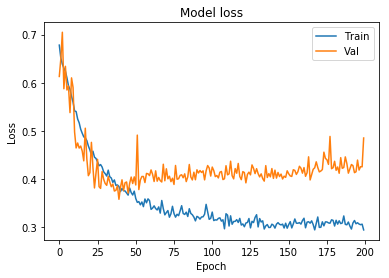

In [485]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

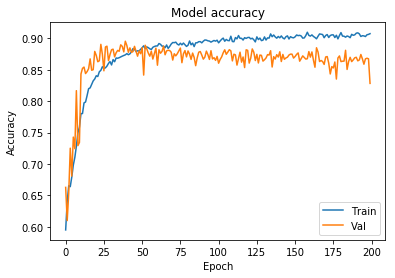

In [486]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [525]:
y_test_pred = (model.predict(X_test)>.5)
from sklearn.metrics import accuracy_score, precision_score, recall_score
Recall=recall_score(y_test,y_test_pred, average=None)
Precision=precision_score(y_test,y_test_pred, average=None)
ACC=accuracy_score(y_test,y_test_pred)
print("acu: ",round(ACC,4))
print("precision:",Precision[0])
print("recall:",Recall[0])

acu:  0.8228
precision: 0.9169440566949425
recall: 0.8868061685445766


# SMOTE Model

In [341]:
X_resample,y_resample=SMOTE().fit_sample(X,y.values.ravel())

In [342]:
y_resample=pd.DataFrame(y_resample)
X_resample=pd.DataFrame(X_resample)

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X_resample, 
                                                    y_resample, test_size = 0.3, 
                                                    random_state=0)

In [344]:
X_train = np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [364]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
#First Hidden Layer
model.add(Dense(269, activation='relu', kernel_initializer='random_normal', input_dim=538))
model.add(Dropout(0.2))
#Second  Hidden Layer
model.add(Dense(134, activation='relu', kernel_initializer='random_normal'))
model.add(Dropout(0.2))
#Second  Hidden Layer
model.add(Dense(75, activation='relu', kernel_initializer='random_normal'))
#Output Layer
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [365]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
hist = model.fit(X_train,y_train, batch_size=15, epochs=30,class_weight=class_weight, validation_data=(X_test, y_test))

Train on 89832 samples, validate on 38500 samples
Epoch 1/30
89832/89832 [==============================] - 22s 249us/step - loss: 0.7916 - acc: 0.5342 - val_loss: 0.6812 - val_acc: 0.5894
Epoch 2/30
89832/89832 [==============================] - 21s 229us/step - loss: 0.5659 - acc: 0.6676 - val_loss: 0.5703 - val_acc: 0.7234
Epoch 3/30
89832/89832 [==============================] - 21s 229us/step - loss: 0.4559 - acc: 0.7610 - val_loss: 0.4506 - val_acc: 0.8054
Epoch 4/30
89832/89832 [==============================] - 21s 230us/step - loss: 0.3959 - acc: 0.8023 - val_loss: 0.4047 - val_acc: 0.8304
Epoch 5/30
89832/89832 [==============================] - 21s 229us/step - loss: 0.3552 - acc: 0.8298 - val_loss: 0.3459 - val_acc: 0.8541
Epoch 6/30
89832/89832 [==============================] - 21s 229us/step - loss: 0.3294 - acc: 0.8442 - val_loss: 0.3469 - val_acc: 0.8551
Epoch 7/30
89832/89832 [==============================] - 21s 231us/step - loss: 0.3038 - acc: 0.8614 - val_loss: 0.

In [353]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[17121  2024]
 [  407 18948]]


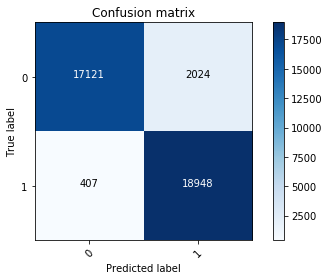

In [366]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test)
y_expected=pd.DataFrame(y_test)

cnf_matrix=confusion_matrix(y_expected,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()

Confusion matrix, without normalization
[[61182  2984]
 [  299  5951]]


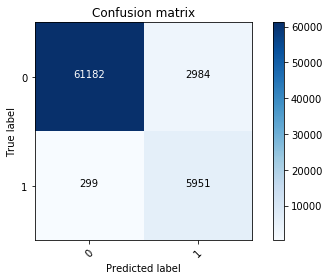

In [367]:
y_pred=model.predict(X)

cnf_matrix=confusion_matrix(y,y_pred.round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()

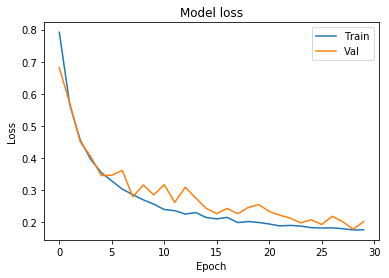

In [368]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

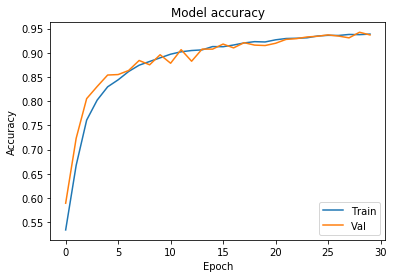

In [369]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

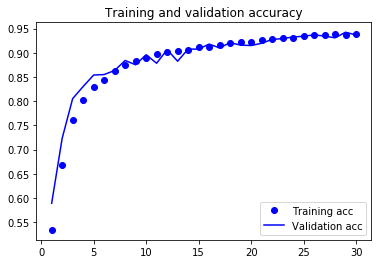

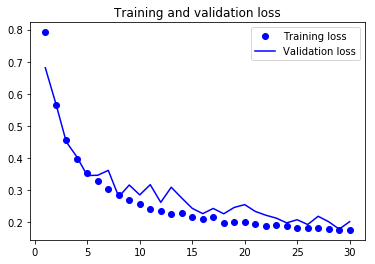

In [376]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

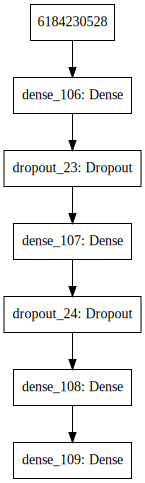

In [370]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [371]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 269)               144991    
_________________________________________________________________
dropout_23 (Dropout)         (None, 269)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 134)               36180     
_________________________________________________________________
dropout_24 (Dropout)         (None, 134)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 75)                10125     
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 76        
Total params: 191,372
Trainable params: 191,372
Non-trainable params: 0
_________________________________________________________________
None

In [477]:
y_test_pred = (model.predict(X_test)>0.4)
from sklearn.metrics import accuracy_score, precision_score, recall_score
Recall=recall_score(y_test,y_test_pred)
Precision=precision_score(y_test,y_test_pred)
ACC=accuracy_score(y_test,y_test_pred)
print("acu: {0:.2f}".format(ACC))
print("precision: {0:.2f}".format(Precision))
print("recall: {0:.2f}".format(Recall))

acu: 0.92
precision: 0.87
recall: 0.99


In [421]:
Fmeasure=((Recall*Precision)/((Recall+Precision)))*2
Fmeasure

0.9269975463401599

In [ ]:
model.save('weights.model')

# base line model

In [399]:
import numpy
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# fix random seed for reproducibility

In [402]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
encoded_Y.shape

(70416,)

In [403]:
# baseline
def create_baseline():
   # create model
        model = Sequential()
        model.add(Dense(269, input_dim=538, kernel_initializer='normal', activation='relu'))
        model.add(Dense(269, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        # Compile model
        sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
        return model
 
seed = 7
numpy.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=16, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 88.02% (0.58%)


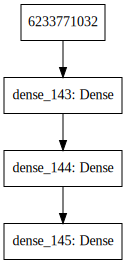

In [404]:
SVG(model_to_dot(create_baseline()).create(prog='dot', format='svg'))

refrences:
https://www.kaggle.com/sid321axn/fraud-detection-deep-learning-with-smote/notebook
https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9
https://secml.github.io/class8/